<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Portrait_Painter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="black" size="+4">Отрисовка портрета</font></b>

<b><font color="black" size="+2">Основан на:</font></b>

**GitHub репозитории**: [U-2-Net](https://github.com/NathanUA/U-2-Net)

**Статья**: [U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf)

**Авторы**: [Xuebin Qin](https://webdocs.cs.ualberta.ca/~xuebin/), [Zichen Zhang](https://webdocs.cs.ualberta.ca/~zichen2/), [Chenyang Huang](https://chenyangh.com/), [Masood Dehghan](https://sites.google.com/view/masooddehghan), [Osmar R. Zaiane](http://webdocs.cs.ualberta.ca/~zaiane/), [Martin Jagersand](https://webdocs.cs.ualberta.ca/~jag/)

<b><font color="black" size="+2">Colab собрал:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

```
Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Устанавливаем все необходимые компоненты</font></b>

!pip install ffmpeg
!pip install youtube-dl

from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from google.colab.patches import cv2_imshow
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from google.colab import files
import numpy as np
import youtube_dl
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import ffmpeg
import cv2
from base64 import b64encode
import os
import io

def display_video(video_path, width=640, clear=True):
  vid_data = open(video_path,'rb').read()
  vid_url = 'data:video/mp4;base64,' + b64encode(vid_data).decode()
  if clear: clear_output()
  return HTML(f"""
  <video width={width} controls>
    <source src={vid_url} type="video/mp4">
  </video>
  """)

!git clone https://github.com/NathanUA/U-2-Net.git
!mkdir /content/U-2-Net/saved_models/u2net_portrait
%cd /content/U-2-Net/saved_models/u2net_portrait
!gdown --id 1IG3HdpcRiDoWNookbncQjeaPN28t90yW
%cd /content/U-2-Net
clear_output()
if len(os.listdir('/content/U-2-Net/saved_models/u2net_portrait')) > 0: print('Все отлично. Можно продолжать!')
else: print('Слишком много желающих протестировать эту нейросеть. Лимити превышены. Скрипт заморожен на несколько часов. Попробуйте через несколько часов.')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Загружаем картинки или видео</font></b>
content = 'photo' #@param ["photo", "video"]
#@markdown *Ниже введите ссылку на фото или видео (например, YouTube), либо оставьте поле **source_url** пустым (в таком случае будет предложено загрузить файл с компьютера).*
source_url = '' #@param {type:"string"}
#@markdown *Откуда бы вы не грузили видео к нему будут применены следующие границы обрезки.*
source_start = '00:00:16' #@param {type:"string"}
source_end = '00:00:23' #@param {type:"string"}
#@markdown *Если хотите оставить первоначальную длинну видео, то полностью сотрите эти две верхние строки.*

!rm -rf /content/U-2-Net/test_data/test_portrait_images/your_portrait_im/*.*
if content == "video":
  !rm -rf /content/source.mp4
  if source_url == '':
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    if source_start!='' or source_end!='': 
      !ffmpeg -y -i $fn -ss $source_start -to $source_end -r 25 /content/source.mp4
    else: 
      !ffmpeg -y -i $fn -r 25 /content/source.mp4
    !rm $fn
    file_name = '/content/source.mp4'
  else:
    try:
      !rm -rf /content/source*
      !youtube-dl $source_url -f bestvideo+bestaudio --merge-output-format mkv -o /content/source_tmp.mkv
      if source_start!='' or source_end!='': 
        !ffmpeg -y -i /content/source_tmp.mkv -ss $source_start -to $source_end -r 25 /content/source.mp4
      else: 
        !ffmpeg -y -i /content/source_tmp.mkv -r 25 /content/source.mp4
      !rm /content/source_tmp.mkv
      file_name = '/content/source.mp4'
    except:
      !wget $source_url
      fn = source_url.split('/')[-1]
      if source_start!='' or source_end!='': 
        !ffmpeg -y -i $fn -ss $source_start -to $source_end -r 25 /content/source.mp4
      else: 
        !ffmpeg -y -i $fn -r 25 /content/source.mp4
      !rm $fn
      file_name = '/content/source.mp4'
  try: 
    clear_output()
    print('Видео загружено. Начался процесс деления на кадры.')
    vidcap = cv2.VideoCapture(file_name)
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      cv2.imwrite("/content/U-2-Net/test_data/test_portrait_images/your_portrait_im/%09d.png" % count, image)
      success,image = vidcap.read()
      count += 1
    fps_of_video = int(cv2.VideoCapture(file_name).get(cv2.CAP_PROP_FPS))
    frames_of_video = int(cv2.VideoCapture(file_name).get(cv2.CAP_PROP_FRAME_COUNT))
    clear_output()
    print('Видео разбито на {} кадров'.format(str(frames_of_video)))
  except: 
    clear_output()
    print("Возникла какая-то ошибка")
else:
  if source_url == '':
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    os.rename(fn, fn.replace(" ", ""))
    fn = fn.replace(" ", "")
    pic_name = "/content/U-2-Net/test_data/test_portrait_images/your_portrait_im/photo." + fn.split(".")[-1]
    !mv -f $fn $pic_name
    clear_output()
    print('Фото успешно загружено')
  else:
    try:
      pic_name = "/content/U-2-Net/test_data/test_portrait_images/your_portrait_im/photo." + source_url.split('.')[-1]
      !wget $source_url -O $pic_name
      clear_output()
      print('Фото успешно загружено')
    except:
      clear_output() 
      print('Что-то пошло не так. Попробуйте загрузить фото с компьютера.')

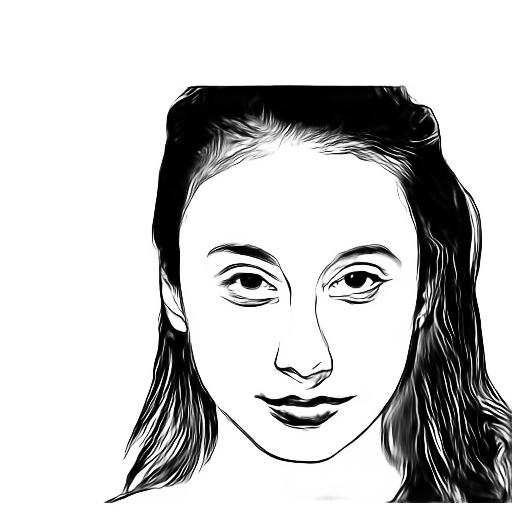

In [71]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Начинаем отрисовку</font></b>

!rm -rf /content/U-2-Net/test_data/test_portrait_images/your_portrait_results/*.*
!python u2net_portrait_demo.py
clear_output()
if content == "video": 
  print('Кадры готовы. Собираем их в видео')
  !ffmpeg -r $fps_of_video -i /content/U-2-Net/test_data/test_portrait_images/your_portrait_results/%09d.png -c:v prores -an /content/result.mp4
  path_to_res = '/content/result.mp4'
  clear_output()
  print('Готово')
else:
  path_to_imgs = '/content/U-2-Net/test_data/test_portrait_images/your_portrait_results/'
  list_pic = os.listdir(path_to_imgs)
  if len(list_pic) == 1:
    path_to_res = path_to_imgs + list_pic[0]
    clear_output()
    cv2_imshow(cv2.imread(path_to_res))
  elif len(list_pic) > 1:
    %cd $path_to_imgs
    !zip archive *
    %cd /content/U-2-Net
    path_to_res = path_to_imgs+'archive.zip'
    clear_output()
    print('Архив с картинками сформирован')
  else: print('Что-то пошло не так')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Скачиваем итоговый файл</font></b>

files.download(path_to_res)